# Load libraries

In [28]:
import os
import warnings

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import torch
from torch import nn
import h5py
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Read Data

In [2]:
DATA_FOLDER = "../input"

all_paths = [
    os.path.join(path, file) for path, _, files in os.walk(top=DATA_FOLDER)
    for file in files 
    if file.endswith('.labels') or file.endswith('.txt')
]

label_names = {0: 'unlabeled', 
               1: 'man-made terrain', 
               2: 'natural terrain', 
               3: 'high vegetation', 
               4: 'low vegetation', 
               5: 'buildings', 
               6: 'hard scape', 
               7: 'scanning artefacts', 
               8: 'cars'}

all_paths

['../input/sem8_labels_training/sem8_labels_training/sg27_station9_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station5_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg28_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg27_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station3_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/neugasse_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station3_xyz_intensity_rgb.labels',
 '../input/sem8_

In [3]:
all_files_df = pd.DataFrame({'path': all_paths})
all_files_df['basename'] = all_files_df['path'].map(os.path.basename)
all_files_df['id'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[0])
all_files_df['ext'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[1][1:])
all_files_df.sample(3)

,path,basename,id,ext
11,../input/sem8_labels_training/sem8_labels_trai...,sg27_station1_intensity_rgb.labels,sg27_station1_intensity_rgb,labels
10,../input/sem8_labels_training/sem8_labels_trai...,sg27_station5_intensity_rgb.labels,sg27_station5_intensity_rgb,labels
7,../input/sem8_labels_training/sem8_labels_trai...,domfountain_station1_xyz_intensity_rgb.labels,domfountain_station1_xyz_intensity_rgb,labels


In [4]:
all_training_pairs = all_files_df.pivot_table(values = 'path', 
                                              columns = 'ext', 
                                              index = ['id'], 
                                              aggfunc = 'first').reset_index().dropna()
all_training_pairs

ext,id,labels,txt
0,bildstein_station1_xyz_intensity_rgb,../input/sem8_labels_training/sem8_labels_trai...,../input/bildstein_station1_xyz_intensity_rgb/...
3,domfountain_station1_xyz_intensity_rgb,../input/sem8_labels_training/sem8_labels_trai...,../input/domfountain_station1_xyz_intensity_rg...


In [5]:
_, test_row = next(all_training_pairs.dropna().tail(1).iterrows())
print(test_row)
read_label_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['class'], index_col = False)
read_xyz_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b'], header = None) #x, y, z, intensity, r, g, b
read_joint_data = lambda c_row, rows: pd.concat([read_xyz_data(c_row['txt'], rows), read_label_data(c_row['labels'], rows)], axis = 1)
read_joint_data(test_row, 10)

ext
id                   domfountain_station1_xyz_intensity_rgb
labels    ../input/sem8_labels_training/sem8_labels_trai...
txt       ../input/domfountain_station1_xyz_intensity_rg...
Name: 3, dtype: object


,x,y,z,intensity,r,g,b,class
0,-22.586,-72.368,0.640,-1365,227,226,231,0
1,-22.580,-72.500,-0.009,-1353,82,87,107,0
2,-22.603,-72.498,-0.030,-1367,96,108,134,0
3,-22.511,-72.496,-0.050,-1349,85,82,91,0
4,-22.512,-72.499,-0.037,-1368,83,80,89,0
5,-23.377,-78.032,-0.104,-1543,73,76,85,0
6,-22.535,-72.499,-0.058,-1344,85,84,92,0
7,-22.556,-72.495,-0.053,-1337,80,79,93,0
8,-22.535,-72.497,-0.036,-1367,84,81,90,0
9,-22.721,-72.514,-0.766,-1473,88,80,93,0


In [6]:
df = read_joint_data(test_row, None)
df.shape

(44990641, 8)

In [7]:
le = LabelEncoder()

df["class"] = le.fit_transform(df["class"])
sorted(df["class"].unique())

[0, 1, 2, 3, 4, 5, 6, 7]

In [8]:
fraction = 0.1
sample = df.sample(frac=fraction)

CPU times: user 739 ms, sys: 224 ms, total: 963 ms
Wall time: 963 ms


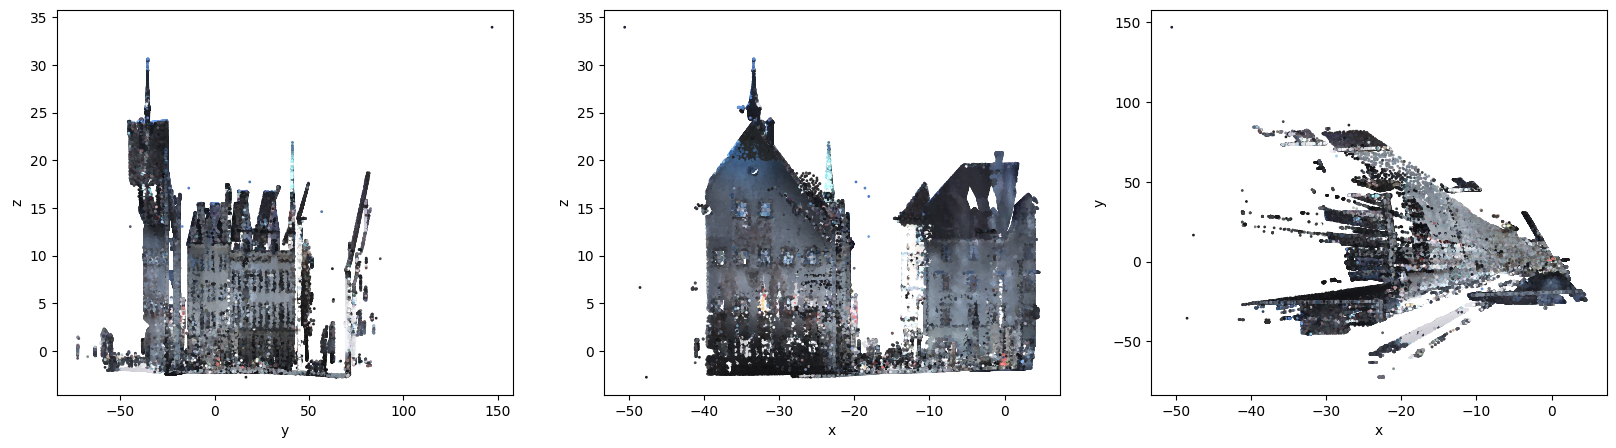

In [9]:
%%time
fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'
for i, c_ax in enumerate(m_axs.flatten()):
    plot_axes = [x for j, x in enumerate(ax_names) if j!=i]
    c_ax.scatter(sample[plot_axes[0]],
                sample[plot_axes[1]],
                c=sample[['r', 'g', 'b']].values / 255, 
                 s=1
                )
    c_ax.set_xlabel(plot_axes[0])
    c_ax.set_ylabel(plot_axes[1])

CPU times: user 1.43 s, sys: 193 ms, total: 1.62 s
Wall time: 1.62 s


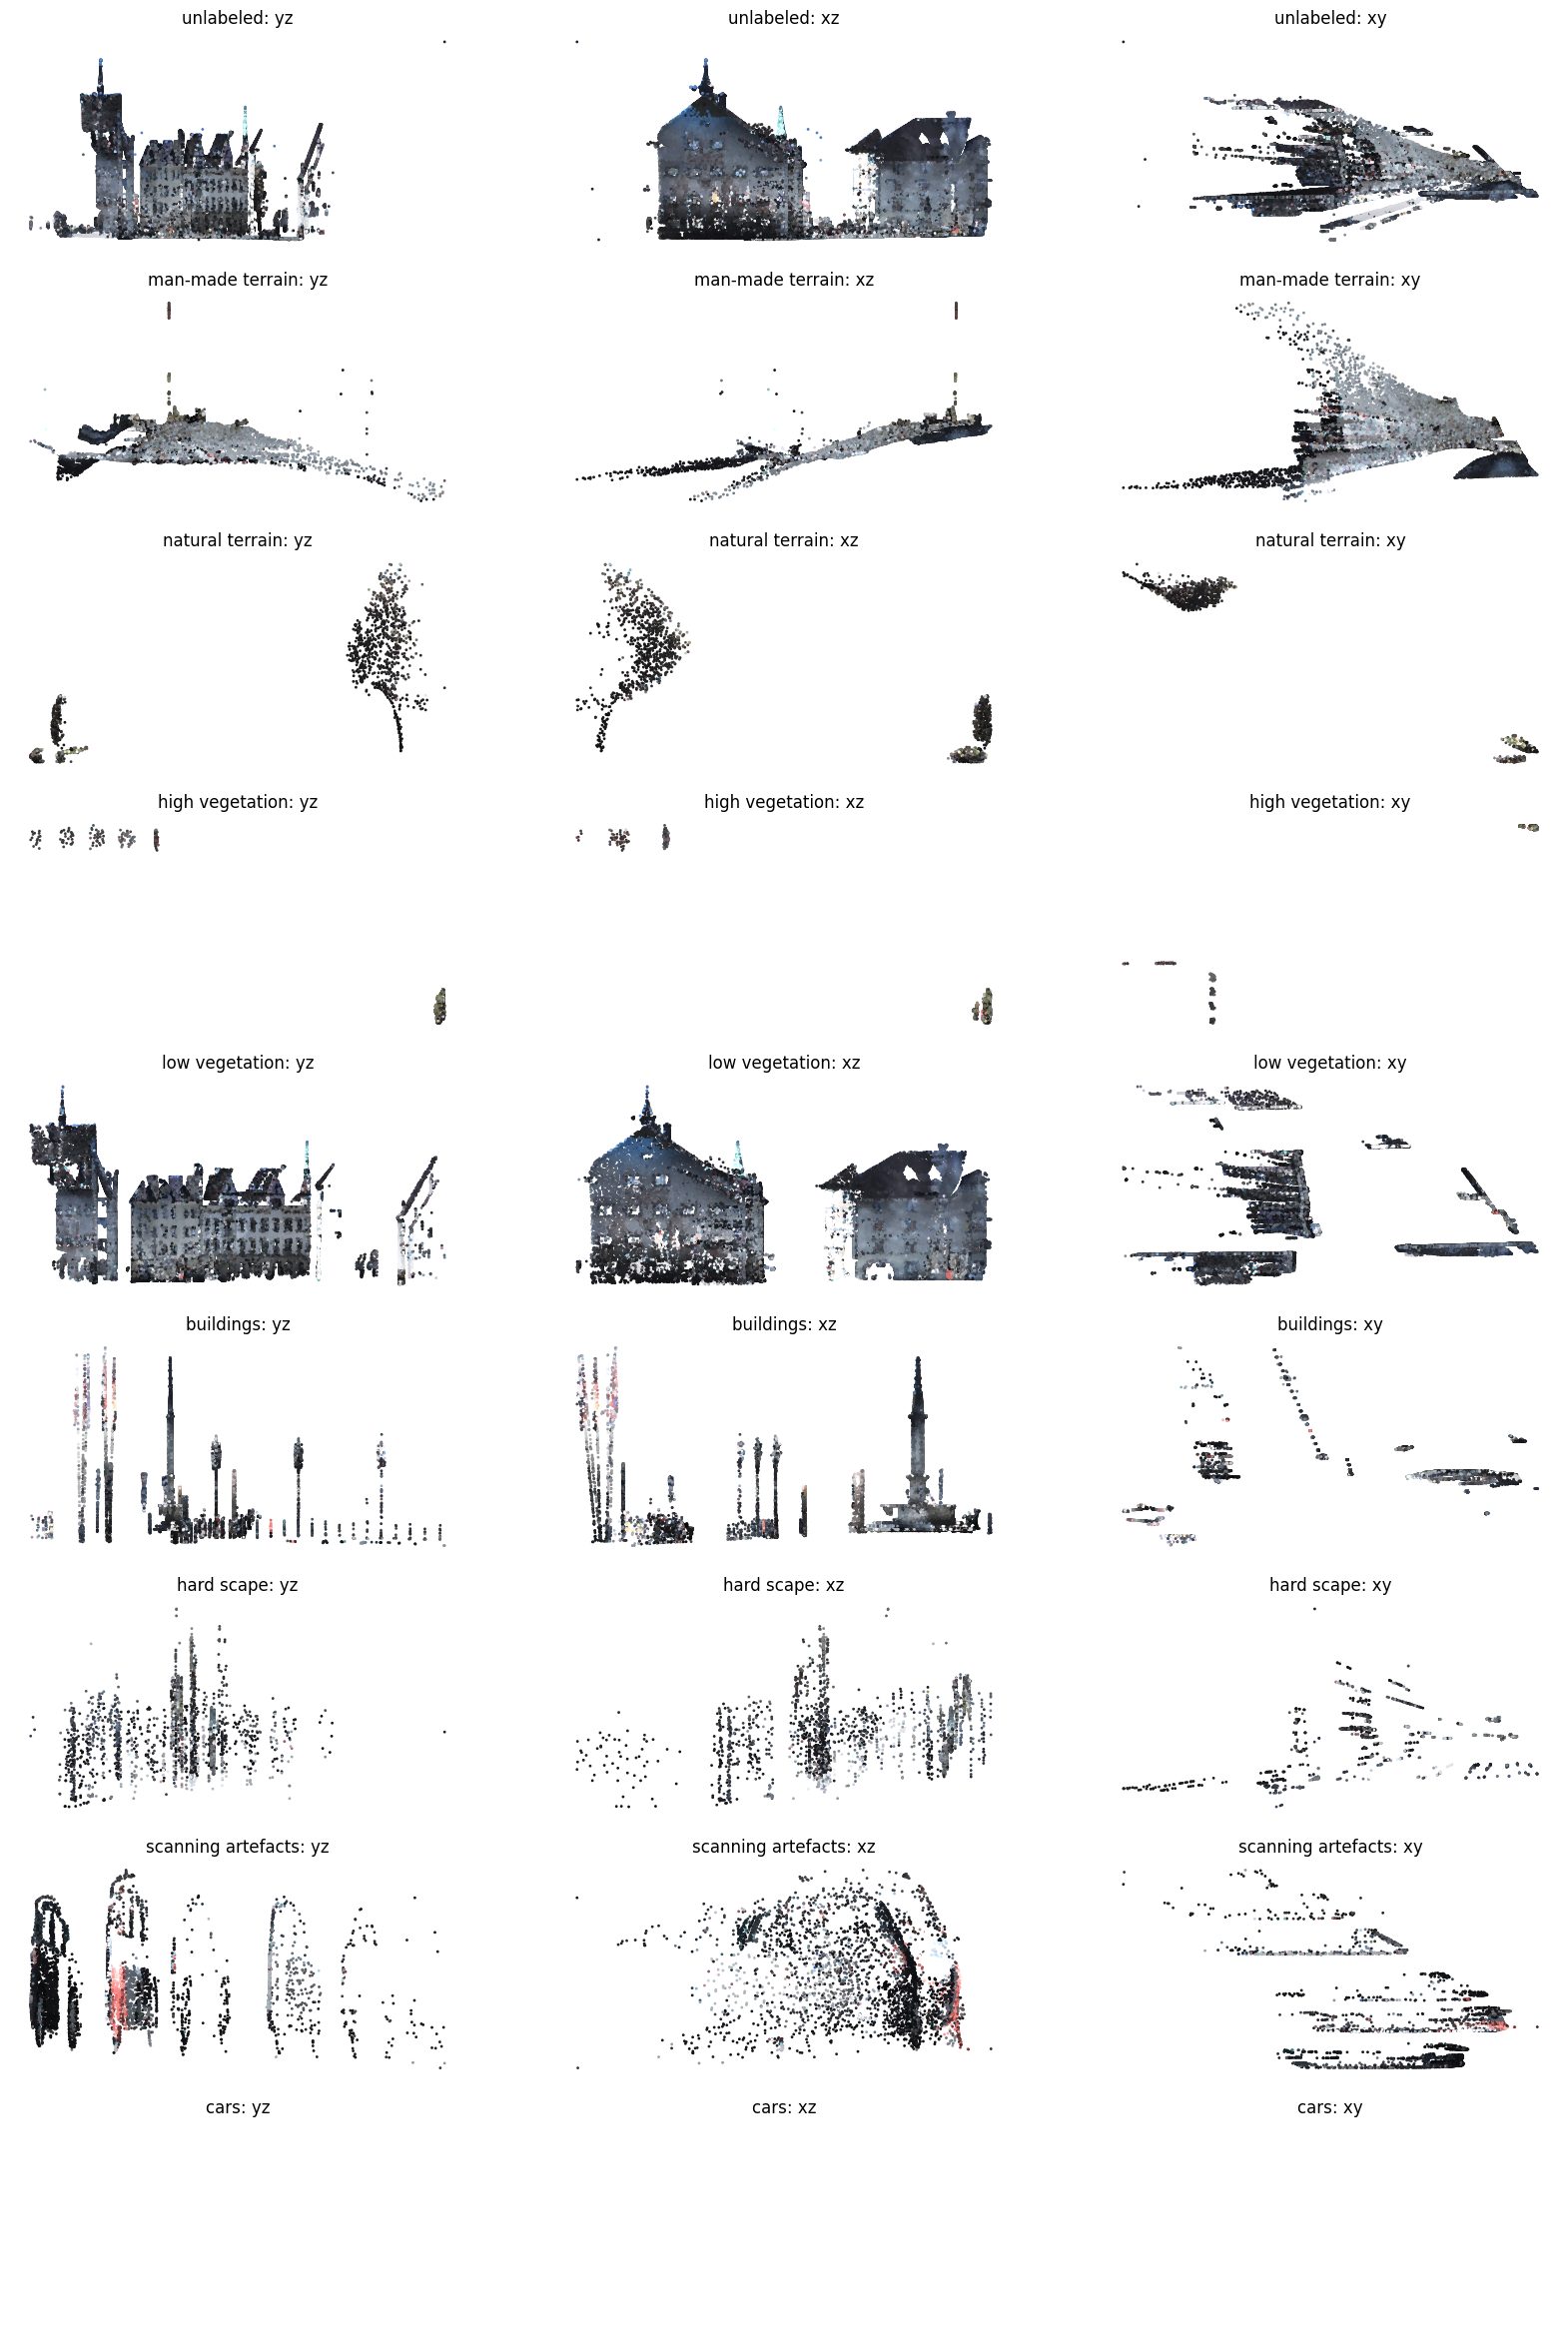

In [10]:
%%time
ax_names = 'xyz'

max_keys = max(label_names.keys())
fig, m_axs = plt.subplots(max_keys + 1, 3, figsize = (20, 30))
for i, c_axs in enumerate(m_axs.T):
    plot_axes = [x for j, x in enumerate(ax_names) if j != i]
    for c_ax, (c_key, c_value) in zip(c_axs, label_names.items()):
        c_df = sample[sample['class'] == c_key]
        c_ax.scatter(
            c_df[plot_axes[0]].values,
            c_df[plot_axes[1]].values,
            c=c_df[["r", "g", "b"]].values / 255,
            label = c_value,
            s=1
        )
        c_ax.set_title('{}: {}'.format(c_value, ''.join(plot_axes)))
        c_ax.set_xlabel(plot_axes[0])
        c_ax.set_ylabel(plot_axes[1])
        c_ax.axis('off')

# Clean data

/tmp/ipykernel_5078/834474999.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["x"], ax=axs[0], kde=False)
/tmp/ipykernel_5078/834474999.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["y"], ax=axs[1], kde=False)
/tmp/ipykernel_5078/834474999.py:4: UserWarning: 

`distplot` is a dep

<Axes: xlabel='z'>

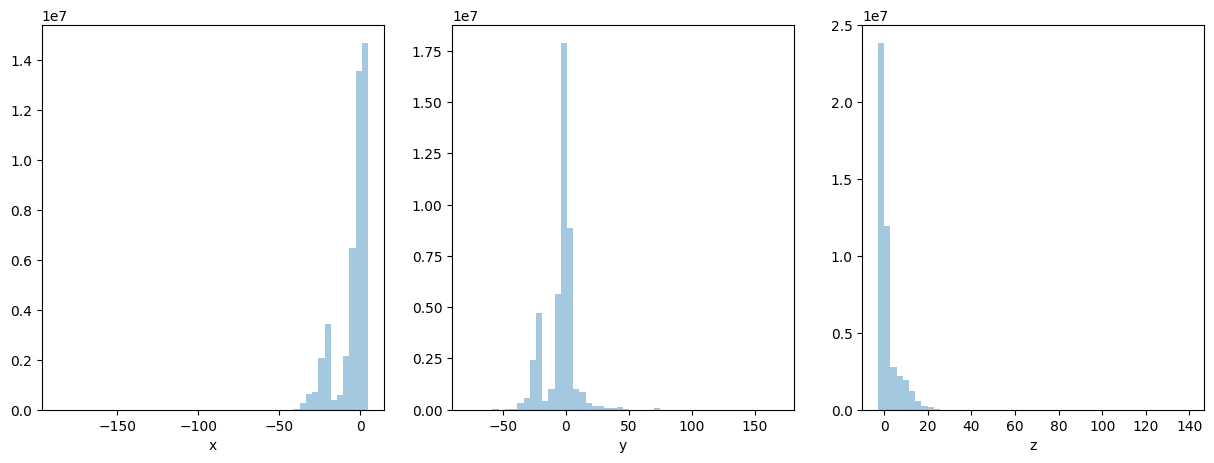

In [11]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.distplot(df["x"], ax=axs[0], kde=False)
sns.distplot(df["y"], ax=axs[1], kde=False)
sns.distplot(df["z"], ax=axs[2], kde=False)

In [12]:
df = df[
    (-50 <= df["x"]) &
    ((-50 <= df["y"]) & (df["y"] <= 50)) &
    (df["z"] <= 25)
]

In [13]:
df = df.dropna()
df.shape

(44825007, 8)

# Graph Neural Networks

In [23]:
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from torch_geometric.data import DataListLoader, Data, DataLoader
from typing import Tuple, List
from sklearn.neighbors import kneighbors_graph

from torch import nn
from transformers import get_constant_schedule

In [14]:
def weights_init_xavier(m):
    '''
    Xavier uniform
    '''
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [18]:
class PointCloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame, features=["x", "y", "z", "intensity", "r", "g", "b"], target_col: str = "class"):
        self.X, self.y = df[features].to_numpy(), df[target_col].to_numpy()
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]


def adj_matrix2edge_index(A: torch.Tensor) -> torch.LongTensor:
    edge_index = A.nonzero().t().contiguous().long()
    return edge_index


class GraphMiner():
    def __init__(self, coordinate_cols: List[int] = [0, 1, 2], n_neighbors: int = 5, norm: str = "l2"):
        """
        :norm: str: ‘cityblock’, ‘cosine’, ‘euclidean’, ‘haversine’, ‘l1’, ‘l2’, ‘manhattan’, ‘nan_euclidean’
        """
        self.coordinate_cols = coordinate_cols
        self.n_neighbors = n_neighbors
        self.norm = norm
        
    def __call__(self, point_cloud_batch: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        A = torch.tensor(
            kneighbors_graph(
                point_cloud_batch[:, self.coordinate_cols].numpy(), 
                self.n_neighbors, 
                mode='connectivity', 
                include_self=True
            ).toarray()
        )
        
        edge_index = adj_matrix2edge_index(A)

        return torch.tensor(point_cloud_batch), edge_index
        

def create_batch_graph(x, edge_index):
    return Data(
              x=x, 
              edge_index=edge_index, 
    )

In [19]:
def train_epoch(model, data_loader, miner, loss_function, optimizer, scheduler, device):
    model.train()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float(),
            batch_target.to(device),
        )
        
        features, edge_index = miner(features)
        graph = create_batch_graph(features.to(device), edge_index.to(device))

        optimizer.zero_grad()
        batch_logits = model(graph)

        logits.append(batch_logits.detach().cpu().squeeze(0))
        targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.double().squeeze(0), batch_target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def eval_epoch(model, data_loader, miner, loss_function, device):
    model.eval()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float(),
            batch_target.to(device),
        )
        
        features, edge_index = miner(features)
        graph = create_batch_graph(features.to(device), edge_index.to(device))

        with torch.no_grad():
            batch_logits = model(graph)

            logits.append(batch_logits.detach().cpu().squeeze(0))
            targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.squeeze(0), batch_target)
        total_train_loss += loss.item()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def cross_validation(
        model,
        dataset,
        miner,
        loss_function,
        optimizer,
        get_scheduler,
        strat_array=None,
        device=torch.device("cuda"),
        random_state: int = 69,
        shuffle: bool = True,
        dataloader_shuffle=False,
        n_folds: int = 4,
        epochs: int = 5,
        lr: float = 1e-6,
        weight_decay: float = 1e-2,
        num_warmup_steps: int = 0,
        start_fold: int = 0,
        batch_size: int = 32,
):
    loss_function.to(device)

    if type(strat_array) != type(None):
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else:
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    fold_train_scores = []
    fold_eval_scores = []

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f"FOLD {fold}")
            print("--------------------------------")

            epoch_train_scores = []
            epoch_eval_scores = []

            fold_model = deepcopy(model)
            fold_model.to(device)

            fold_optimizer = optimizer(
                fold_model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
            )

            train_subsampler = torch.utils.data.Subset(dataset, train_ids)
            train_loader = torch.utils.data.DataLoader(
                train_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            eval_subsampler = torch.utils.data.Subset(dataset, eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                eval_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            total_steps = len(train_loader) * epochs

            if get_scheduler != get_constant_schedule:
                scheduler = get_scheduler(
                    fold_optimizer,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=total_steps
                )
            else:
                scheduler = get_scheduler(
                    fold_optimizer,
                )

            for epoch_i in range(epochs):
                train_metrics = train_epoch(
                    fold_model,
                    train_loader,
                    miner,
                    loss_function,
                    fold_optimizer,
                    scheduler,
                    device,
                )
                eval_metrics = eval_epoch(
                    fold_model,
                    eval_loader,
                    miner,
                    loss_function,
                    device,
                )

                epoch_train_scores.append(train_metrics)
                epoch_eval_scores.append(eval_metrics)

                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)

        fold_train_scores.append(epoch_train_scores)
        fold_eval_scores.append(epoch_eval_scores)

    return fold_train_scores, fold_eval_scores

In [20]:
from torch_geometric.nn import GCNConv, BatchNorm, Linear


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels * 5, hidden_channels)

        self.norm1 = BatchNorm(hidden_channels)
        self.norm2 = BatchNorm(hidden_channels)
        self.norm3 = BatchNorm(hidden_channels)
        self.norm4 = BatchNorm(hidden_channels)
        self.norm5 = BatchNorm(hidden_channels)
        self.norm6 = BatchNorm(hidden_channels)
 
        self.lin = Linear(hidden_channels, 8)
 
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x1 = self.norm1(x1)
 
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()
        x2 = self.norm2(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = x3.relu()
        x3 = self.norm3(x3)
 
        x4 = self.conv4(x3, edge_index)
        x4 = x4.relu()
        x4 = self.norm4(x4)
         
        x5 = self.conv5(x4, edge_index)
        x5 = x5.relu()
        x5 = self.norm5(x5)
 
        x6 = self.conv6(torch.hstack([x1, x2, x3, x4, x5]), edge_index)
        x6 = x6.relu()
        x6 = self.norm6(x6)
        
        return self.lin(x6) 
    
    
model = GNN(hidden_channels=128)
weights_init_xavier(model)

In [24]:
train, test = train_test_split(
    df,
    stratify=df["class"], 
    test_size=0.2
)

In [25]:
train_dataset = PointCloudDataset(train)

In [26]:
from sklearn.utils.class_weight import compute_class_weight


loss = nn.CrossEntropyLoss(
       weight=torch.tensor(
        compute_class_weight(
            class_weight="balanced",
            classes=sorted(train["class"].unique()),
            y=train["class"].to_numpy()
        )
    )
)

In [ ]:
MINER_METRIC = "l2"
N_NEIGHBORS = 10

N_SPLITS = 6
EPOCHS = 3
LR = 1e-3
RANDOM_STATE = 42
SHUFFLE = True
BATCH_SIZE = 2048

miner = GraphMiner(
    coordinate_cols=[0, 1, 2],
    n_neighbors=N_NEIGHBORS, 
    norm=MINER_METRIC
)

train_scores, eval_scores = cross_validation(
        model=model,
        dataset=train_dataset,
        miner=miner,
        loss_function=loss,
        optimizer=torch.optim.AdamW,
        get_scheduler=get_constant_schedule,
        strat_array=train["class"],
        device="cpu",
        random_state=RANDOM_STATE,
        shuffle=SHUFFLE,
        dataloader_shuffle=False,
        n_folds=N_SPLITS,
        epochs=EPOCHS,
        lr=LR,
        weight_decay=1e-2,
        num_warmup_steps=0,
        start_fold=0,
        batch_size=BATCH_SIZE
)

FOLD 0
--------------------------------


  0%|          | 0/14592 [00:00<?, ?it/s]

In [ ]:
baccs = []
accs = []
f1s = []

for fold_score in eval_scores:
    score = fold_score[-1]
    baccs.append(score["Balanced Accuracy"])
    accs.append(score["Accuracy"])
    f1s.append(score["F1 Weighted"])
    
mean_balanced_acc = np.mean(baccs)
std_balanced_acc = np.std(baccs)

mean_acc = np.mean(accs)
std_acc = np.std(accs)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

print(f"Balanced Accuracy: {mean_balanced_acc} ± {std_balanced_acc}")
print(f"Accuracy: {mean_acc} ± {std_acc}")
print(f"F1 Weighted: {mean_f1} ± {std_f1}")